### NOTEBOOK CONTENTS:

1. Actors Graph Creation based on movie ratings distribution
2. Community Detection
3. On the found communities, Sub-graphs creation based on topic distribution
4. Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
m_meta = pd.read_csv("/content/drive/MyDrive/movies_big/movies_metadata.csv")
m_meta.drop_duplicates(subset=['id'], inplace=True)
m_meta['genres'] = m_meta['genres'].apply(lambda x: eval(x))
m_meta.dropna(subset=['title'], inplace=True)
m_meta['production_companies'] = m_meta['production_companies'].apply(lambda x: eval(x))
m_meta['id'] = m_meta['id'].astype(int)
m_meta.dropna(subset=['imdb_id'], inplace=True)
m_meta['imdbId']=m_meta['imdb_id'].apply(lambda x: int(x.replace("tt", "")))
m_meta['genre_list'] = m_meta['genres'].apply(lambda x:  [g['name'] for g in x])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
links_df = pd.read_csv("/content/drive/MyDrive/movies_big/emb/links.csv")
ratings_df = pd.read_csv("/content/drive/MyDrive/movies_big/emb/ratings.csv")
credits_df = pd.read_csv("/content/drive/MyDrive/movies_big/credits.csv")

In [4]:
credits_df['cast'] = credits_df['cast'].apply(lambda x: eval(x))

In [5]:
m_ids = []
c_ids = []
c_name = []
for _iter, row in credits_df.iterrows():
    cast_list = row['cast']
    m_id = row['id']
    for cast in cast_list:
        c_ids.append(cast['id'])
        c_name.append(cast['name'])
        m_ids.append(m_id)
len(m_ids), len(c_ids), len(c_name)

(562474, 562474, 562474)

In [6]:
cast_df = pd.DataFrame({'cast_id':c_ids, 'cast_name':c_name, 'id':m_ids})
cast_df = cast_df.merge(links_df, left_on='id', right_on='tmdbId')
cast_df = cast_df.merge(m_meta[['id', 'vote_average']], left_on='movieId', right_on='id')

In [7]:
cast_df.head(3)

,cast_id,cast_name,id_x,movieId,imdbId,tmdbId,id_y,vote_average
0,2157,Robin Williams,8844,2,113497,8844.0,2,7.1
1,8537,Jonathan Hyde,8844,2,113497,8844.0,2,7.1
2,205,Kirsten Dunst,8844,2,113497,8844.0,2,7.1


In [8]:
cast_ratings = pd.DataFrame(cast_df.groupby('cast_id').agg({
    'vote_average': lambda x: x.tolist()
}).rename({'vote_average':'ratings'}, axis=1).reset_index())
cast_ratings['avg_rating'] = cast_ratings['ratings'].apply(lambda x: np.mean(x))

In [9]:
cast_ratings.head(1)

,cast_id,ratings
0,1,"[5.4, 5.7, 5.6]"


In [10]:
cast_ratings.shape

(60701, 2)

In [11]:
cast_ratings = cast_ratings[cast_ratings['ratings'].apply(lambda x: True if len(x)>5 else False)]

In [12]:
cast_ratings.shape

(2646, 2)

T-TEST based graph creation

In [31]:
import scipy
def return_edge_list(entity, scores):
    edge_list = []
    for idx1 in range(len(entity)-1):
        for idx2 in range(idx1+1, len(entity)):
            ent1 = entity[idx1]
            ent2 = entity[idx2]
            score1 = scores[idx1]
            score2 = scores[idx2]
            p_val = scipy.stats.ttest_ind(score1, score2)
            #print(p_val[1])
            if p_val[1] > 0.05:
                edge_list.append([ent1, ent2])
        print(idx1)
    return edge_list

In [35]:
production_edges = return_edge_list(cast_ratings['cast_id'].values, cast_ratings['ratings'].values)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
len(production_edges)

3269727

In [37]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(production_edges)

In [38]:
import community as community_louvain
partition = community_louvain.best_partition(G, weight='weight')
np.unique(list(partition.values()))

array([0, 1])

In [49]:
community_df = pd.DataFrame({'cast_id':list(partition.keys()), 'community':list(partition.values())})

In [51]:
cast_ratings = cast_ratings.merge(community_df)

In [60]:
scipy.stats.ttest_ind(cast_ratings[cast_ratings['community']==0]['avg_rating'], cast_ratings[cast_ratings['community']==1]['avg_rating'])

Ttest_indResult(statistic=-56.64290348056189, pvalue=0.0)

In [63]:
np.mean(cast_ratings[cast_ratings['community']==0]['avg_rating'])/2, np.mean(cast_ratings[cast_ratings['community']==1]['avg_rating'])/2

(2.831099099396861, 3.2623796986124094)

In [80]:
cast_ratings['community'].value_counts()

1    1349
0    1297
Name: community, dtype: int64

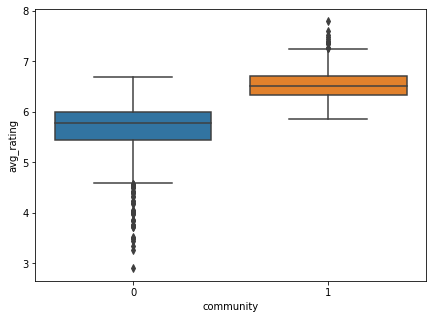

In [83]:
plt.figure(figsize=(7,5))
sns.boxplot(y=cast_ratings['avg_rating'], x=cast_ratings['community'])

In [88]:
bad_actors = nx.pagerank(G.subgraph(community_df[community_df['community']==0]['cast_id'].values))
good_actors = nx.pagerank(G.subgraph(community_df[community_df['community']==1]['cast_id'].values))

In [ ]:
def name_actor(cast_df, x):
    return cast_df[cast_df['cast_id']==x]['cast_name'].values[0]

In [105]:
[(x[0], name_actor(cast_df, x[0]), x[1]) for x in sorted(bad_actors.items(), key=lambda x:x[1], reverse=True)[:20]]

[(1904, 'Anthony Michael Hall', 0.0007790130919335551),
 (1926, 'Eddie Izzard', 0.0007790130919335551),
 (18313, 'Michael Rispoli', 0.0007790130919335551),
 (10224, 'Clifton James', 0.0007790130919335551),
 (2055, 'Robert Davi', 0.0007790130919335551),
 (59410, 'Bob Odenkirk', 0.0007790130919335551),
 (2141, 'Ned Bellamy', 0.0007790130919335551),
 (51310, 'Henry Wilcoxon', 0.0007790130919335551),
 (10367, 'John Waters', 0.0007790130919335551),
 (10461, 'Caroline Munro', 0.0007790130919335551),
 (26847, 'Adam West', 0.0007790130919335551),
 (1145, 'Zbigniew Zamachowski', 0.0007790130919335549),
 (50398, 'Devon Sawa', 0.0007790130919335549),
 (1272, 'Richard Bradford', 0.0007790130919335549),
 (1284, 'Noah Taylor', 0.0007790130919335549),
 (42279, 'Laura Fraser', 0.0007790130919335549),
 (34098, 'Ernie Adams', 0.0007790130919335549),
 (148868, 'Will Stanton', 0.0007790130919335549),
 (34187, 'Chuck Hamilton', 0.0007790130919335549),
 (83362, 'Dennis Burkley', 0.0007790130919335549)]

In [102]:
[(x[0], name_actor(cast_df, x[0]), x[1]) for x in sorted(good_actors.items(), key=lambda x:x[1], reverse=True)[:20]]

[(14405, 'Courteney Cox', 0.0007488870853460844),
 (6930, 'Diane Baker', 0.0007488870853460843),
 (7090, 'Kelsey Grammer', 0.0007488870853460843),
 (7621, 'Courtney Love', 0.0007488870853460843),
 (7631, 'Stella Stevens', 0.0007488870853460843),
 (7863, 'Tantoo Cardinal', 0.0007488870853460843),
 (8183, 'Kathleen Quinlan', 0.0007488870853460843),
 (8198, 'Ulrich Tukur', 0.0007488870853460843),
 (8253, 'Robert Ryan', 0.0007488870853460843),
 (8256, 'Anne Heche', 0.0007488870853460843),
 (8262, 'L.Q. Jones', 0.0007488870853460843),
 (8318, 'Brian Blessed', 0.0007488870853460843),
 (8608, 'Murray Hamilton', 0.0007488870853460843),
 (8727, 'Basil Rathbone', 0.0007488870853460843),
 (8728, 'Eugene Pallette', 0.0007488870853460843),
 (8730, 'Melville Cooper', 0.0007488870853460843),
 (8792, 'Lynn Cohen', 0.0007488870853460843),
 (8830, 'Henry B. Walthall', 0.0007488870853460843),
 (8874, 'Ernie Hudson', 0.0007488870853460843),
 (8949, 'Peter Fonda', 0.0007488870853460843)]

In [112]:
cast_ratings['name']=cast_ratings['cast_id'].apply(lambda x: name_actor(cast_df, x))

In [116]:
cast_ratings.sort_values(by=['avg_rating'])[:15]

,cast_id,ratings,avg_rating,community,name
2535,109701,"[0.0, 0.0, 2.9, 6.0, 0.0, 7.0, 6.3, 0.0, 3.9]",2.900000,0,Barbara Hale
2414,83203,"[6.9, 5.7, 0.0, 1.0, 0.0, 6.0]",3.266667,0,Fujio Suga
2397,80704,"[8.5, 6.9, 7.0, 1.0, 0.0, 0.0, 0.0]",3.342857,0,Shintarô Katsu
2542,116157,"[6.6, 5.0, 3.5, 5.5, 0.0, 0.0]",3.433333,0,Vesa-Matti Loiri
857,6832,"[4.9, 6.7, 7.8, 0.0, 5.0, 0.0, 0.0]",3.485714,0,Melissa Leo
2313,64896,"[6.1, 6.1, 2.9, 0.0, 5.9, 0.0]",3.500000,0,Michael Wong
948,8171,"[6.1, 4.7, 0.0, 5.0, 5.3, 0.0]",3.516667,0,Ludacris
2544,116494,"[5.5, 4.0, 2.1, 4.3, 5.0, 2.6, 1.7, 4.5]",3.712500,0,Eddy Waller
1277,12139,"[5.1, 6.1, 4.5, 0.0, 5.1, 0.0, 5.3]",3.728571,0,Lolita Davidovich
1851,26727,"[6.4, 5.6, 1.0, 5.0, 4.5, 0.0]",3.750000,0,Dean Shek


In [121]:
cast_ratings.sort_values(by=['avg_rating'], ascending=False)[:15]

,cast_id,ratings,avg_rating,community,name
429,2750,"[7.4, 7.7, 7.2, 7.4, 6.8, 8.0, 10.0]",7.785714,1,Julie Harris
337,2171,"[6.8, 6.6, 6.9, 6.3, 9.0, 10.0]",7.600000,1,Griffin Dunne
2040,34285,"[8.2, 7.0, 6.6, 8.3, 8.0, 7.0]",7.516667,1,William Frawley
1977,31007,"[7.5, 7.2, 7.9, 8.2, 7.6, 7.4, 6.6]",7.485714,1,John Capodice
466,3026,"[7.7, 7.9, 8.3, 7.9, 7.2, 6.6, 7.0, 6.9]",7.437500,1,Rob Reiner
853,6774,"[6.9, 7.4, 8.1, 5.8, 6.2, 10.0]",7.400000,1,Joe Santos
1082,9781,"[7.3, 7.9, 7.1, 6.4, 8.5, 7.1]",7.383333,1,Nia Long
695,4943,"[6.3, 7.4, 7.9, 7.3, 7.9, 7.4]",7.366667,1,Bruce A. Young
1860,27164,"[7.6, 6.8, 7.7, 6.5, 8.0, 7.6]",7.366667,1,Frank Baker
253,1581,"[8.3, 7.0, 8.2, 7.8, 6.7, 7.9, 5.4]",7.328571,1,Mary McDonnell


In [127]:
cast_df = cast_df.merge(m_meta[['revenue','id']], how='left', left_on='movieId', right_on='id')

In [135]:
cast_meta = cast_df.groupby('cast_id').agg({
    'id':lambda x:x.tolist(),
    'revenue':lambda x:x.tolist()
}).rename({'id':'movie_ids'}).reset_index()

In [140]:
cast_ratings = cast_ratings.merge(cast_meta)

In [144]:
cast_ratings['non_zero_revenue_avg'] = cast_ratings['revenue'].apply(lambda x: np.mean([i for i in x if i!=0]))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [151]:
cast_ratings['non_zero_revenue_avg'].fillna(0, inplace=True)

In [155]:
bad_revenue = np.mean(cast_ratings[cast_ratings['community']==0]['non_zero_revenue_avg'])
good_revenue = np.mean(cast_ratings[cast_ratings['community']==1]['non_zero_revenue_avg'])

In [157]:
bad_revenue, good_revenue

(96876559.67341343, 113256525.10497771)

In [160]:
((good_revenue-bad_revenue)/bad_revenue)*100

16.9080791956112

In [162]:
cast_ratings.to_csv("/content/drive/MyDrive/movies_big/emb/actor_community_df.csv", index=False)

In [163]:
cast_ratings

,cast_id,ratings,avg_rating,community,name,id,revenue,non_zero_revenue_avg
0,2,"[7.4, 4.3, 6.6, 5.0, 7.0, 7.0, 0.0]",5.328571,0,Mark Hamill,"[260, 332, 4734, 45047, 74436, 99351, 173433]","[0.0, 0.0, 138000.0, 0.0, 0.0, 0.0, 0.0]",1.380000e+05
1,3,"[7.4, 5.1, 7.3, 6.9, 0.0, 5.3, 6.4, 5.4, 8.2, ...",5.780000,0,Harrison Ford,"[260, 349, 457, 541, 1488, 1608, 1894, 2115, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 649398328.0, 0....",6.493983e+08
2,4,"[7.4, 7.5, 7.3, 6.7, 5.7, 6.5, 6.6, 5.9, 7.3, ...",6.458333,1,Carrie Fisher,"[260, 1126, 2072, 3048, 3489, 4228, 4734, 8884...","[0.0, 0.0, 0.0, 0.0, 16930884.0, 0.0, 138000.0...",8.534442e+06
3,5,"[7.4, 6.9, 6.8, 5.8, 6.6, 7.1, 4.5, 4.7, 2.7, ...",5.800000,0,Peter Cushing,"[260, 1941, 2652, 5552, 5595, 6976, 8743, 2626...","[0.0, 21750000.0, 7022209.0, 0.0, 0.0, 0.0, 0....",9.625238e+06
4,13,"[8.0, 7.1, 7.2, 6.4, 6.9, 6.1, 6.9, 6.6, 6.3]",6.833333,1,Albert Brooks,"[111, 1414, 1677, 1911, 1912, 5769, 42740, 516...","[65884703.0, 0.0, 124731534.0, 61698899.0, 0.0...",7.247878e+07
...,...,...,...,...,...,...,...,...
2641,1395666,"[7.2, 6.7, 4.0, 7.7, 5.1, 8.0]",6.450000,1,Edward Biby,"[922, 954, 3122, 3936, 41831, 113757]","[0.0, 457696359.0, 0.0, 0.0, 0.0, 0.0]",4.576964e+08
2642,1422389,"[7.4, 6.7, 6.8, 6.4, 5.1, 1.7]",5.683333,0,Jesse Graves,"[923, 954, 1934, 7219, 41831, 84643]","[55000000.0, 457696359.0, 289317794.0, 0.0, 0....",2.673381e+08
2643,1468172,"[7.4, 6.6, 6.6, 8.1, 6.4, 7.3, 1.7]",6.300000,0,Tom Coleman,"[923, 953, 1942, 3780, 8491, 9008, 84643]","[55000000.0, 532680671.0, 0.0, 0.0, 30218387.0...",1.695472e+08
2644,1584544,"[6.4, 5.9, 5.9, 7.6, 7.7, 7.2, 6.3, 7.5, 6.5, ...",6.544444,1,Philip Ettington,"[6, 296, 318, 527, 593, 628, 1266, 1387, 1589,...","[12136938.0, 435000000.0, 0.0, 2201126.0, 0.0,...",1.027557e+08


Topics Analysis

In [1]:
!pip install contextualized-topic-models

     |████████████████████████████████| 81kB 4.7MB/s 
     |████████████████████████████████| 13.1MB 322kB/s 
     |████████████████████████████████| 14.5MB 241kB/s 
     |████████████████████████████████| 24.2MB 97kB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 368kB 30.8MB/s 
     |████████████████████████████████| 2.0MB 24.9MB/s 
     |████████████████████████████████| 1.2MB 27.1MB/s 
     |████████████████████████████████| 890kB 37.3MB/s 
     |████████████████████████████████| 3.2MB 36.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1-cp37-none-any.whl size=103051 sha256=2058959dd4d351c232e47dd99ed392cc083d1123180c2faeba808c5a3fe57300
  Stored in directory: /root/.cache/pip/wheels/4d/61/1e/d8a2fc8fcfc0f86af8477bcdbca4a8832dd9230e2051c82cb0
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=95b6e98f6ab340f29896b8f96c8060ab886a54099f0c2cda26a991f73c75

In [1]:
import joblib
m_ids = joblib.load("/content/drive/MyDrive/movies_big/topic/m_ids.pkl")
topic_vectors = joblib.load("/content/drive/MyDrive/movies_big/topic/topic_vectors.pkl")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
m_topics_vecs = {}
for m_id, m_vec in zip(m_ids, topic_vectors):
    m_topics_vecs[m_id]=m_vec

In [5]:
def mean_topic_vector(ids):
    idxs = [idx for idx, mid in enumerate(m_ids) if mid in ids]
    return np.mean(topic_vectors[idxs], axis=0)

In [12]:
cast_ratings = pd.read_csv("/content/drive/MyDrive/movies_big/emb/actor_community_df.csv")

In [17]:
cast_ratings['id'] = cast_ratings['id'].apply(lambda x: eval(x))

In [19]:
actor_vectors = {}
for _, row in cast_ratings.iterrows():
    c_id = row['cast_id']
    c_vec = mean_topic_vector(row['id'])
    actor_vectors[c_id]=c_vec

In [20]:
bad_actor_ids = cast_ratings[cast_ratings['community']==0]['cast_id'].values
good_actor_ids = cast_ratings[cast_ratings['community']==1]['cast_id'].values

In [21]:
set(good_actor_ids).intersection(bad_actor_ids)

set()

In [22]:
cast_ratings.shape

(2646, 9)

In [23]:
good_actor_mat = []
bad_actor_mat = []
for idx, row in cast_ratings.iterrows():
    if row['community']==0:
        bad_actor_mat.append(actor_vectors[row['cast_id']])
    else:
        good_actor_mat.append(actor_vectors[row['cast_id']])
good_actor_mat = np.array(good_actor_mat)
bad_actor_mat = np.array(bad_actor_mat)

In [204]:
import scipy
import numpy as np
import networkx as nx

In [199]:
from sklearn import metrics
def create_weighted_adjacency_mat(mat, thresh):
    mat[mat<thresh]=0
    return mat

In [239]:
sim_mat = metrics.pairwise.cosine_similarity(good_actor_mat)

In [240]:
sim_mat = create_weighted_adjacency_mat(sim_mat, 0.85)
np.fill_diagonal(sim_mat, 0)

In [241]:
r_keep_idxs = ~np.all(sim_mat == 0, axis=1)
c_keep_idxs = ~np.all(sim_mat.T == 0, axis=1)
print("Sanity: ", np.all(r_keep_idxs == c_keep_idxs))
sum(r_keep_idxs)

Sanity:  True


1349

In [242]:
print(sim_mat.shape)
sim_mat = scipy.sparse.csr_matrix(sim_mat)
sim_mat = sim_mat[r_keep_idxs]
sim_mat = sim_mat.T[c_keep_idxs].T
print(sim_mat.shape)

(1349, 1349)
(1349, 1349)


In [243]:
G = nx.convert_matrix.from_scipy_sparse_matrix(sim_mat)
partition = community_louvain.best_partition(G, weight='weight')
community_louvain.modularity(partition, G, weight='weight')

0.11487265695579309

In [244]:
np.unique(list(partition.values()))

array([0, 1, 2, 3, 4])

In [245]:
good_community_df = pd.DataFrame({'cast_id':list(cast_ratings[cast_ratings['community']==1]['cast_id']), 'sub_community':list(partition.values())})

In [247]:
sim_mat = metrics.pairwise.cosine_similarity(bad_actor_mat)
sim_mat = create_weighted_adjacency_mat(sim_mat, 0.85)
np.fill_diagonal(sim_mat, 0)
r_keep_idxs = ~np.all(sim_mat == 0, axis=1)
c_keep_idxs = ~np.all(sim_mat.T == 0, axis=1)
print("Sanity: ", np.all(r_keep_idxs == c_keep_idxs))
sum(r_keep_idxs)

Sanity:  True


1297

In [248]:
print(sim_mat.shape)
sim_mat = scipy.sparse.csr_matrix(sim_mat)
sim_mat = sim_mat[r_keep_idxs]
sim_mat = sim_mat.T[c_keep_idxs].T
print(sim_mat.shape)

(1297, 1297)
(1297, 1297)


In [249]:
G = nx.convert_matrix.from_scipy_sparse_matrix(sim_mat)
partition = community_louvain.best_partition(G, weight='weight')
community_louvain.modularity(partition, G, weight='weight')

0.14547247174975295

In [250]:
np.unique(list(partition.values()))

array([0, 1, 2, 3])

In [251]:
partition.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [252]:
bad_community_df = pd.DataFrame({'cast_id':list(cast_ratings[cast_ratings['community']==0]['cast_id']), 'sub_community':list(partition.values())})

In [253]:
good_bad_community_df = good_community_df.append(bad_community_df)

In [254]:
len(good_bad_community_df['cast_id'].unique())

2646

In [226]:
good_actor_mat.shape[0]+bad_actor_mat.shape[0]

2646

In [256]:
cast_ratings = cast_ratings.merge(good_bad_community_df, how='left', on='cast_id')

In [257]:
cast_ratings.to_csv("/content/drive/MyDrive/movies_big/emb/actor_community_df.csv", index=False)

In [260]:
cast_ratings.head()

,cast_id,ratings,avg_rating,community,name,id,revenue,non_zero_revenue_avg,sub_community
0,2,"[7.4, 4.3, 6.6, 5.0, 7.0, 7.0, 0.0]",5.328571,0,Mark Hamill,"[260, 332, 4734, 45047, 74436, 99351, 173433]","[0.0, 0.0, 138000.0, 0.0, 0.0, 0.0, 0.0]",1.380000e+05,0
1,3,"[7.4, 5.1, 7.3, 6.9, 0.0, 5.3, 6.4, 5.4, 8.2, ...",5.780000,0,Harrison Ford,"[260, 349, 457, 541, 1488, 1608, 1894, 2115, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 649398328.0, 0....",6.493983e+08,1
2,4,"[7.4, 7.5, 7.3, 6.7, 5.7, 6.5, 6.6, 5.9, 7.3, ...",6.458333,1,Carrie Fisher,"[260, 1126, 2072, 3048, 3489, 4228, 4734, 8884...","[0.0, 0.0, 0.0, 0.0, 16930884.0, 0.0, 138000.0...",8.534442e+06,3
3,5,"[7.4, 6.9, 6.8, 5.8, 6.6, 7.1, 4.5, 4.7, 2.7, ...",5.800000,0,Peter Cushing,"[260, 1941, 2652, 5552, 5595, 6976, 8743, 2626...","[0.0, 21750000.0, 7022209.0, 0.0, 0.0, 0.0, 0....",9.625238e+06,2
4,13,"[8.0, 7.1, 7.2, 6.4, 6.9, 6.1, 6.9, 6.6, 6.3]",6.833333,1,Albert Brooks,"[111, 1414, 1677, 1911, 1912, 5769, 42740, 516...","[65884703.0, 0.0, 124731534.0, 61698899.0, 0.0...",7.247878e+07,1


In [27]:
good_cast_ratings = cast_ratings[cast_ratings['community']==1].reset_index()
bad_cast_ratings = cast_ratings[cast_ratings['community']==0].reset_index()

In [28]:
from itertools import chain

In [29]:
good_coms = pd.DataFrame(good_cast_ratings.groupby('sub_community').agg({
    'cast_id':lambda x: x.tolist(),
    'avg_rating':lambda x: x.tolist(),
    'id':lambda x: list(chain.from_iterable(x.tolist())),
    'non_zero_revenue_avg':lambda x: x.tolist()
}).reset_index())

bad_coms = pd.DataFrame(bad_cast_ratings.groupby('sub_community').agg({
    'cast_id':lambda x: x.tolist(),
    'avg_rating':lambda x: x.tolist(),
    'id':lambda x: list(chain.from_iterable(x.tolist())),
    'non_zero_revenue_avg':lambda x: x.tolist()
}).reset_index())

In [30]:
good_coms

,sub_community,cast_id,avg_rating,id,non_zero_revenue_avg
0,0,"[228, 290, 478, 504, 783, 1039, 1064, 1461, 15...","[6.761111111111113, 6.063157894736843, 6.72857...","[14, 150, 257, 276, 454, 1127, 1682, 3016, 311...","[133531834.0, 100663400.83333331, 0.0, 7846591..."
1,1,"[13, 52, 102, 110, 112, 349, 388, 452, 500, 50...","[6.833333333333332, 6.2875, 6.5875, 6.76923076...","[111, 1414, 1677, 1911, 1912, 5769, 42740, 516...","[72478784.0, 59101833.5, 293213925.3333333, 18..."
2,2,"[31, 33, 35, 62, 109, 138, 139, 147, 194, 207,...","[6.742105263157897, 6.525, 6.08, 6.3, 6.13125,...","[150, 508, 539, 581, 2028, 2072, 2100, 3114, 3...","[116409890.75, 45599073.0, 35514077.0, 1364815..."
3,3,"[4, 20, 32, 40, 98, 155, 193, 227, 230, 378, 4...","[6.458333333333332, 6.262499999999998, 6.75555...","[260, 1126, 2072, 3048, 3489, 4228, 4734, 8884...","[8534442.0, 28455841.25, 76195685.6, 52230566...."
4,4,"[18, 53, 65, 130, 131, 190, 205, 206, 287, 351...","[6.25, 6.235294117647059, 6.141176470588236, 6...","[158, 2355, 5482, 46972, 53569, 81847, 112460,...","[22222308.0, 104777336.14285716, 139261493.6, ..."


In [31]:
bad_coms

,sub_community,cast_id,avg_rating,id,non_zero_revenue_avg
0,0,"[2, 85, 99, 212, 326, 385, 477, 540, 569, 935,...","[5.328571428571427, 5.839130434782607, 5.9, 5....","[260, 332, 4734, 45047, 74436, 99351, 173433, ...","[138000.0, 118765643.875, 237473390.0, 5770254..."
1,1,"[3, 48, 64, 114, 134, 141, 192, 454, 515, 529,...","[5.78, 5.5705882352941165, 5.9823529411764715,...","[260, 349, 457, 541, 1488, 1608, 1894, 2115, 2...","[649398328.0, 158294428.33333334, 111107616.16..."
2,2,"[5, 23, 50, 113, 204, 350, 380, 448, 516, 517,...","[5.800000000000002, 6.333333333333332, 5.62666...","[260, 1941, 2652, 5552, 5595, 6976, 8743, 2626...","[9625237.666666666, 516729786.0, 107339167.0, ..."
3,3,"[19, 34, 63, 118, 258, 335, 429, 526, 649, 725...","[6.044444444444445, 5.8909090909090915, 5.5454...","[438, 664, 994, 1810, 1894, 2295, 45431, 46772...","[293502505.5, 64559092.66666666, 7665067.0, 89..."


In [32]:
good_vecs = []
for _, row in good_coms.iterrows():
    cast_ids = row['cast_id']
    mean_vec = []
    for c_id in cast_ids:
        mean_vec.append(actor_vectors[c_id])
    mean_vec = np.mean(mean_vec,axis=0)
    good_vecs.append(mean_vec)

bad_vecs = []
for _, row in bad_coms.iterrows():
    cast_ids = row['cast_id']
    mean_vec = []
    for c_id in cast_ids:
        mean_vec.append(actor_vectors[c_id])
    mean_vec = np.mean(mean_vec,axis=0)
    bad_vecs.append(mean_vec)

In [33]:
len(good_vecs), len(bad_vecs)

(5, 4)

In [34]:
good_coms

,sub_community,cast_id,avg_rating,id,non_zero_revenue_avg
0,0,"[228, 290, 478, 504, 783, 1039, 1064, 1461, 15...","[6.761111111111113, 6.063157894736843, 6.72857...","[14, 150, 257, 276, 454, 1127, 1682, 3016, 311...","[133531834.0, 100663400.83333331, 0.0, 7846591..."
1,1,"[13, 52, 102, 110, 112, 349, 388, 452, 500, 50...","[6.833333333333332, 6.2875, 6.5875, 6.76923076...","[111, 1414, 1677, 1911, 1912, 5769, 42740, 516...","[72478784.0, 59101833.5, 293213925.3333333, 18..."
2,2,"[31, 33, 35, 62, 109, 138, 139, 147, 194, 207,...","[6.742105263157897, 6.525, 6.08, 6.3, 6.13125,...","[150, 508, 539, 581, 2028, 2072, 2100, 3114, 3...","[116409890.75, 45599073.0, 35514077.0, 1364815..."
3,3,"[4, 20, 32, 40, 98, 155, 193, 227, 230, 378, 4...","[6.458333333333332, 6.262499999999998, 6.75555...","[260, 1126, 2072, 3048, 3489, 4228, 4734, 8884...","[8534442.0, 28455841.25, 76195685.6, 52230566...."
4,4,"[18, 53, 65, 130, 131, 190, 205, 206, 287, 351...","[6.25, 6.235294117647059, 6.141176470588236, 6...","[158, 2355, 5482, 46972, 53569, 81847, 112460,...","[22222308.0, 104777336.14285716, 139261493.6, ..."


Community: 0
Avg Rating: 6.57 Avg Revenue 106068951.0
Top 3 topics: [13  8  2  7]


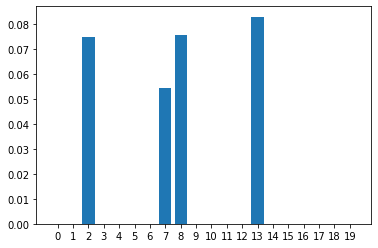

Community: 1
Avg Rating: 6.5 Avg Revenue 139035377.72
Top 3 topics: [17  7 16  5]


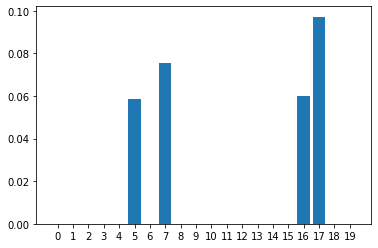

Community: 2
Avg Rating: 6.5 Avg Revenue 101885295.28
Top 3 topics: [6 5 0 3]


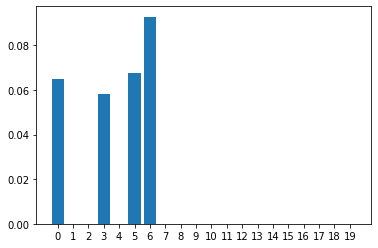

Community: 3
Avg Rating: 6.59 Avg Revenue 109399512.42
Top 3 topics: [19 14 18  5]


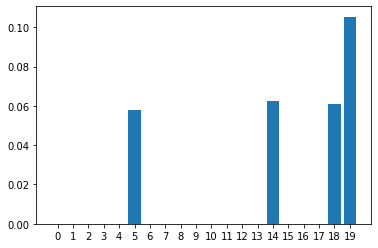

Community: 4
Avg Rating: 6.51 Avg Revenue 100808288.49
Top 3 topics: [12 10 15  9]


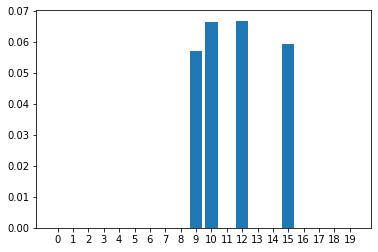

In [306]:
t_idxs = []
for t_vec in (good_vecs):
    t_idxs.append(np.argsort(t_vec)[::-1][:4])
for c_id, v in enumerate(good_vecs):

    print("Community:",c_id)
    print("Avg Rating:", np.round(np.mean(good_coms.iloc[c_id]['avg_rating']),2), "Avg Revenue", np.round(np.mean(good_coms.iloc[c_id]['non_zero_revenue_avg']),2))
    # print("Top 3 topics:", t_idxs[c_id])
    # com_vector = np.zeros(vec.shape)
    # com_vector[t_idxs[c_id]] = vec[t_idxs[c_id]]
    # plt.bar(x=range(len(v)),height=v)
    # plt.xticks(range(len(v)))
    # plt.show()

    print("Top 3 topics:", t_idxs[c_id])
    com_vector = np.zeros(v.shape)
    com_vector[t_idxs[c_id]] = v[t_idxs[c_id]]
    plt.bar(range(len(com_vector)), com_vector)
    plt.xticks(range(len(com_vector)))
    plt.show()

Community: 0
Top 3 topics: [ 7 19 17  6]


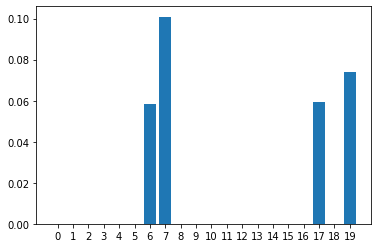

Community: 1
Top 3 topics: [10 15  3 12]


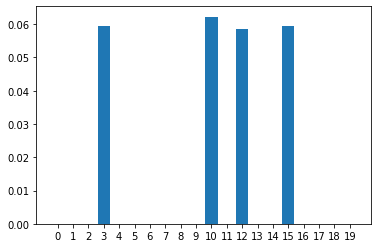

Community: 2
Top 3 topics: [17 16  5  7]


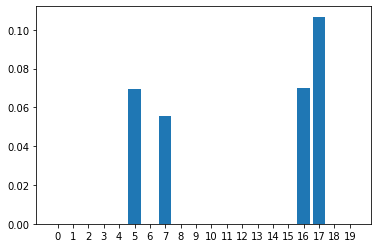

Community: 3
Top 3 topics: [13  8  2 19]


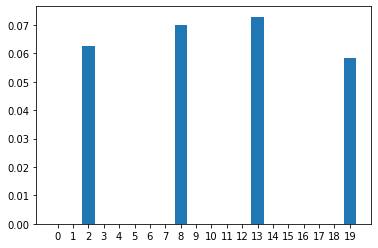

In [298]:
t_idxs = []
for t_vec in (bad_vecs):
    t_idxs.append(np.argsort(t_vec)[::-1][:4])
for c_id, v in enumerate(bad_vecs):

    print("Community:",c_id)
    # print("Top 3 topics:", t_idxs[c_id])
    # com_vector = np.zeros(vec.shape)
    # com_vector[t_idxs[c_id]] = vec[t_idxs[c_id]]
    # plt.bar(x=range(len(v)),height=v)
    # plt.xticks(range(len(v)))
    # plt.show()

    print("Top 3 topics:", t_idxs[c_id])
    com_vector = np.zeros(v.shape)
    com_vector[t_idxs[c_id]] = v[t_idxs[c_id]]
    plt.bar(range(len(com_vector)), com_vector)
    plt.xticks(range(len(com_vector)))
    plt.show()

In [307]:
print(1)

1


In [38]:
good_vecs = np.array(good_vecs)
bad_vecs = np.array(bad_vecs)

In [61]:
t_idxs = []
# for t_vec in (community_topic_vecs-mean_com_topic_vec):
for t_vec in (good_vecs):
    t_idxs.append(np.argsort(t_vec)[::-1][:3])

cluster_ids = []
t_vecs = []
for c_id, vec in enumerate(good_vecs):  
    com_vector = np.zeros(vec.shape)
    com_vector[t_idxs[c_id]] = vec[t_idxs[c_id]]
    # data_viz.append({'cluster_id':int(c_id), 'topic_vector':list(com_vector)})
    cluster_ids.append(c_id)
    t_vecs.append(com_vector)

t_vecs = np.array(t_vecs)
t_vecs = t_vecs/np.sum(t_vecs, axis=1).reshape(-1,1)
t_vecs = np.round(t_vecs, 2)

Text(87.0, 0.5, 'Good Actor Communities IDs')

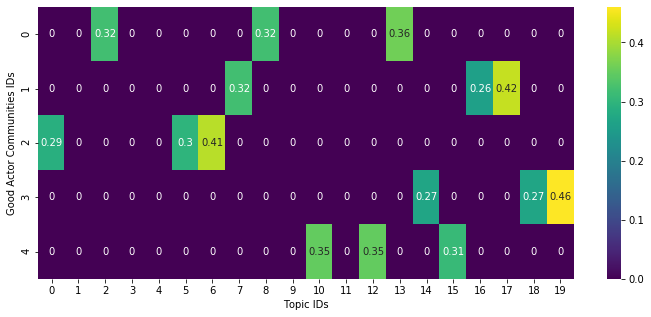

In [62]:
plt.figure(figsize=(12,5))
sns.heatmap(t_vecs, annot=True, cmap='viridis')
plt.xlabel("Topic IDs")
plt.ylabel("Good Actor Communities IDs")

In [63]:
t_idxs = []
# for t_vec in (community_topic_vecs-mean_com_topic_vec):
for t_vec in (bad_vecs):
    t_idxs.append(np.argsort(t_vec)[::-1][:3])

cluster_ids = []
t_vecs = []
for c_id, vec in enumerate(bad_vecs):  
    com_vector = np.zeros(vec.shape)
    com_vector[t_idxs[c_id]] = vec[t_idxs[c_id]]
    # data_viz.append({'cluster_id':int(c_id), 'topic_vector':list(com_vector)})
    cluster_ids.append(c_id)
    t_vecs.append(com_vector)

t_vecs = np.array(t_vecs)
t_vecs = t_vecs/np.sum(t_vecs, axis=1).reshape(-1,1)
t_vecs = np.round(t_vecs, 2)

Text(87.0, 0.5, 'Bad Actor Communities IDs')

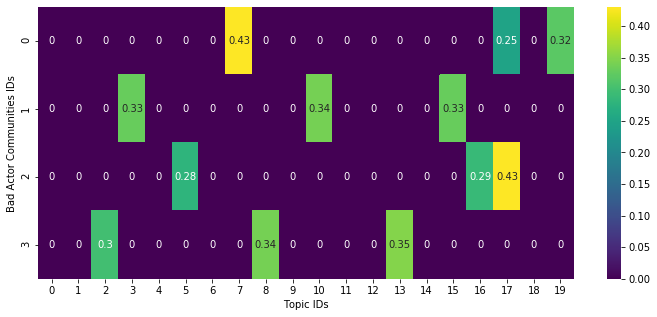

In [64]:
plt.figure(figsize=(12,5))
sns.heatmap(t_vecs, annot=True, cmap='viridis')
plt.xlabel("Topic IDs")
plt.ylabel("Bad Actor Communities IDs")

In [66]:
bad_coms['avg_rating'].apply(lambda x: np.mean(x))

0    5.640081
1    5.659626
2    5.661175
3    5.691898
Name: avg_rating, dtype: float64

In [71]:
good_coms['avg_rating'].apply(lambda x: np.mean(x))

0    6.573677
1    6.497940
2    6.496551
3    6.587199
4    6.514758
Name: avg_rating, dtype: float64